<a href="https://colab.research.google.com/github/rrsguim/PhD_Economics/blob/master/NN4BC/TL_LSTM_1df_locked.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

------------------------------------------------------------------------------------------------------
Copyright (c) 2020 Rafael Guimaraes

This work was done when I was at the University of California, Riverside, USA. 

It is part of my doctoral thesis in Economics at the Federal University of 

Rio Grande do Sul, Porto Alegre, Brazil.


See full material at https://github.com/rrsguim/PhD_Economics

The code below, under the Apache License, was inspired by

*Classification on imbalanced data*, and 

*Introduction to the Keras Tuner*

Copyright 2020 The TensorFlow Authors

https://www.tensorflow.org/tutorials/structured_data/imbalanced_data

https://www.tensorflow.org/tutorials/keras/keras_tuner

-------------------------------------------------------------------------

# Transfer Learning for Business Cycle Identification

##Setup

In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals

In [ ]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

In [ ]:
!pip install -U keras-tuner

Requirement already up-to-date: keras-tuner in /usr/local/lib/python3.6/dist-packages (1.0.1)


In [ ]:
import tensorflow as tf
from tensorflow import keras

import IPython

import kerastuner as kt
from kerastuner import RandomSearch

import os
import tempfile

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [ ]:
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

## Deep Learning | United States

###Data loading and pre-processing

#### Download the data set

##### The Dataset

We use FRED Economic Data, provided by the Federal Reserve Bank of Saint Louis. There are several rows in the CSV file. Each row corresponds to a quarter, and each column describes an attribute. We will use this information to infer whether the US Economy is in recession, which in this dataset is a binary classification task.

Following is a description of this dataset. Notice that there are both numeric and categorical columns. All data refer to United States of America from 1967Q1 to 2019Q4.

>Column| Source| Description| Feature Type | Data Type
>------------|--------------------|----------------------|-----------------|----------------
>GDP | FRED-MD | GDPC1 - Real Gross Domestic Product, s.a. | Numerical | float
>Income | FRED-MD | PIECTR - Real personal income ex current transfer receipts, s.a. | Numerical | float
>Employment | FRED-MD | PRS85006013 - Nonfarm Business Sector employment index, s.a. | Numerical | float
>Industry | FRED-MD | IPB50001SQ - Industrial production index, s.a. | Numerical | float
>Sales | FRED-MD | CQRMTSPL - Real manufacturing and trade industries sales, s.a. | Numerical | float
>Target | FRED-MD | USRECQ - NBER based Recession Indicator (1 = true; 0 = false) | Classification | integer

In [ ]:
file = tf.keras.utils
raw_data = pd.read_csv('https://raw.githubusercontent.com/rrsguim/PhD_Economics/master/NN4BC/TL4BC_US_data.csv')

In [ ]:
raw_data.index = raw_data['DATE']
drop_DATE = raw_data.pop('DATE')
raw_data.index = pd.to_datetime(raw_data.index,infer_datetime_format=True)
raw_data.index = raw_data.index.to_period("Q")

#### Examine the class label imbalance

In [ ]:
neg, pos = np.bincount(raw_data['NBER'])
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Examples:
    Total: 212
    Positive: 27 (12.74% of total)



#### Transform the features into log first difference.

In [ ]:
log_data = raw_data.copy()

log_data['GDP'] = np.log(log_data['GDP'])
log_data['Income'] = np.log(log_data['Income'])
log_data['Employment'] = np.log(log_data['Employment'])
log_data['Industry'] = np.log(log_data['Industry'])
log_data['Sales'] = np.log(log_data['Sales'])

In [ ]:
log_1df = log_data.copy()

log_1df['GDP'] = log_data['GDP'] - log_data['GDP'].shift(1)
log_1df['Income'] = log_data['Income'] - log_data['Income'].shift(1)
log_1df['Employment'] = log_data['Employment'] - log_data['Employment'].shift(1)
log_1df['Industry'] = log_data['Industry'] - log_data['Industry'].shift(1)
log_1df['Sales'] = log_data['Sales'] - log_data['Sales'].shift(1)

Cut the first line because of NaN in lag features and observe last lines of the adjusted dataset.

In [ ]:
log_1df = log_1df[1:]
log_1df.tail()

,GDP,Income,Employment,Industry,Sales,NBER
DATE,,,,,,
2018Q4,0.002710,0.005645,0.004112,0.009481,0.003436,0
2019Q1,0.007623,0.009776,0.001403,-0.004879,0.014956,0
2019Q2,0.004985,0.004228,0.000904,-0.005700,-0.005293,0
2019Q3,0.005204,0.001736,0.007021,0.002808,0.009172,0
2019Q4,0.005261,0.005844,0.001715,0.000877,0.000543,0


Observe last lines of the adjusted dataset.

#### Inspect pre-processed data

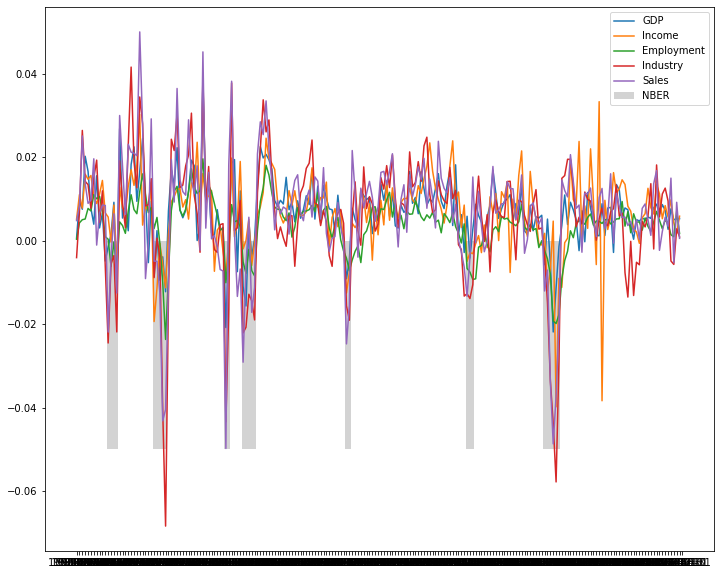

In [ ]:
plt.plot(drop_DATE[1:], log_1df['GDP'], label='GDP')
plt.plot(drop_DATE[1:], log_1df['Income'], label='Income')
plt.plot(drop_DATE[1:], log_1df['Employment'], label='Employment')
plt.plot(drop_DATE[1:], log_1df['Industry'], label='Industry')
plt.plot(drop_DATE[1:], log_1df['Sales'], label='Sales')
plt.bar(drop_DATE, raw_data['NBER']/-20, width=1, linewidth=1, align='center', color="lightgray", label='NBER') 
plt.legend()
plt.show()

#### Split, but no shuffle

Split the dataset into train, validation, and test sets. The validation set is used during the model fitting to evaluate the loss and any metrics, however, the model is not fit with this data. The test set is completely unused during the training phase and is only used at the end to evaluate how well the model generalizes to new data. This is especially important with imbalanced datasets where overfitting is a significant concern from the lack of training data.

In [ ]:
# Use a utility from sklearn to split our dataset.
train_df, test_df = train_test_split(log_1df, test_size=0.4, random_state=0, shuffle=False)  #then we have two recessions on test_set
train_df, val_df = train_test_split(train_df, test_size=0.3, random_state=0, shuffle=False)  

# Form np arrays of labels and features.
train_labels = np.array(train_df.pop('NBER'))
#bool_train_labels = train_labels != 0
val_labels = np.array(val_df.pop('NBER'))
test_labels = np.array(test_df.pop('NBER'))

train_features = np.array(train_df)
val_features = np.array(val_df)
test_features = np.array(test_df)

#### Normalize

Normalize the input features using the sklearn StandardScaler.
This will set the mean to 0 and standard deviation to 1.

Note: The `StandardScaler` is only fit using the `train_features` to be sure the model is not peeking at the validation or test sets. 

In [ ]:
scaler = StandardScaler()
train_features = scaler.fit_transform(train_features)

val_features = scaler.transform(val_features)
test_features = scaler.transform(test_features)

train_features = np.clip(train_features, -5, 5)
val_features = np.clip(val_features, -5, 5)
test_features = np.clip(test_features, -5, 5)


Adjust model input dim because of LSTM

In [ ]:
train_features = np.expand_dims(train_features, 1)
val_features = np.expand_dims(val_features, 1)
test_features = np.expand_dims(test_features, 1)

#### Initial bias

The correct bias to set can be derived from:

$$ p_0 = pos/(pos + neg) = 1/(1+e^{-b_0}) $$
$$ b_0 = -log_e(1/p_0 - 1) $$
$$ b_0 = log_e(pos/neg)$$

Set that as the initial bias, and the model will give much more reasonable initial guesses.

In [ ]:
initial_bias = np.log([pos/neg])

### Define the model and metrics

Define a function that creates a simple neural network with a densly connected hidden layer, a [dropout](https://developers.google.com/machine-learning/glossary/#dropout_regularization) layer to reduce overfitting, and an output sigmoid layer that returns the probability of recession. Also, pick the optimal set of hyperparameters with [Keras Tunner](https://www.tensorflow.org/tutorials/keras/keras_tuner).

In [ ]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]


def make_model(hp, metrics = METRICS, output_bias = initial_bias):  
  output_bias = tf.keras.initializers.Constant(output_bias)

  model = keras.Sequential()
  #model.add(keras.layers.Flatten(input_shape=(train_features.shape[-1],))) 
  
  # Tune the number of units in the layers
  # Choose an optimal value between 16-256
  hp_units = hp.Int('units', min_value = 16, max_value = 256, step = 16)
  
  model.add(keras.layers.LSTM(units = hp_units, input_shape = (1,train_features.shape[-1],), dropout = 0.3)) #LSTM layer
 
  model.add(keras.layers.Dense(units = hp_units, activation = 'relu')) #Dense layer 1
  model.add(keras.layers.Dense(units = hp_units, activation = 'relu')) #Dense layer 2
  model.add(keras.layers.Dense(units = hp_units, activation = 'relu')) #Dense layer 3
  model.add(keras.layers.Dense(units = hp_units, activation = 'relu')) #Dense layer 4

  model.add(keras.layers.Dropout(0.5)) # To prevent overfiting

  model.add(keras.layers.Dense(1, activation='sigmoid', bias_initializer=output_bias)) # Output layer

  # Tune the learning rate for the optimizer 
  # Choose an optimal value from 0.01, 0.001, or 0.0001
  hp_learning_rate = hp.Choice('learning_rate', values = [1e-2, 1e-3, 1e-4])

  model.compile(optimizer = keras.optimizers.Adam(learning_rate = hp_learning_rate),
                loss = keras.losses.BinaryCrossentropy(), 
                metrics = metrics)
  
  return model


In [ ]:
tuner = kt.Hyperband(make_model,
                     kt.Objective('val_auc', direction='max'), # Maximizes Area Under the ROC Curve
                     max_epochs = 10,
                     factor = 3,)
                     #project_name = 'TL4BC')

#### Understanding useful metrics

Notice that there are a few metrics defined above that can be computed by the model that will be helpful when evaluating the performance.



*   **False** negatives and **false** positives are samples that were **incorrectly** classified
*   **True** negatives and **true** positives are samples that were **correctly** classified
*   **Accuracy** is the percentage of examples correctly classified
>   $\frac{\text{true samples}}{\text{total samples}}$
*   **Precision** is the percentage of **predicted** positives that were correctly classified
>   $\frac{\text{true positives}}{\text{true positives + false positives}}$
*   **Recall** is the percentage of **actual** positives that were correctly classified
>   $\frac{\text{true positives}}{\text{true positives + false negatives}}$
*   **AUC** refers to the Area Under the Curve of a Receiver Operating Characteristic curve (ROC-AUC). This metric is equal to the probability that a classifier will rank a random positive sample higher than than a random negative sample.


Read more:
*  [True vs. False and Positive vs. Negative](https://developers.google.com/machine-learning/crash-course/classification/true-false-positive-negative)
*  [Accuracy](https://developers.google.com/machine-learning/crash-course/classification/accuracy)
*   [Precision and Recall](https://developers.google.com/machine-learning/crash-course/classification/precision-and-recall)
*   [ROC-AUC](https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc)

### Train the model

Before running the hyperparameter search, define a callback to clear the training outputs at the end of every training step.

In [ ]:
class ClearTrainingOutput(tf.keras.callbacks.Callback):
  def on_train_end(*args, **kwargs):
    IPython.display.clear_output(wait = True)

Run the hyperparameter search. The arguments for the search method are the same as those used for tf.keras.model.fit in addition to the callback above.

In [ ]:
tuner.search(train_features, train_labels,
             epochs=50,
             validation_data=(val_features, val_labels), callbacks = [ClearTrainingOutput()])

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the
layers is {best_hps.get('units')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")

INFO:tensorflow:Oracle triggered exit

The hyperparameter search is complete. The optimal number of units in the
layers is 176 and the optimal learning rate for the optimizer
is 0.01.



Retrain the model with the optimal hyperparameters from the search.

In [ ]:
# Build the model with the optimal hyperparameters and train it on the data
model = tuner.hypermodel.build(best_hps)
baseline_history = model.fit(train_features, train_labels,
             epochs=50,
             validation_data=(val_features, val_labels))

Epoch 1/50
3/3 [==============================] - 1s 382ms/step - loss: 0.3756 - tp: 7.0000 - fp: 1.0000 - tn: 107.0000 - fn: 11.0000 - accuracy: 0.9048 - precision: 0.8750 - recall: 0.3889 - auc: 0.7613 - val_loss: 0.3316 - val_tp: 2.0000 - val_fp: 7.0000 - val_tn: 29.0000 - val_fn: 0.0000e+00 - val_accuracy: 0.8158 - val_precision: 0.2222 - val_recall: 1.0000 - val_auc: 1.0000
Epoch 2/50
3/3 [==============================] - 0s 13ms/step - loss: 0.2639 - tp: 12.0000 - fp: 3.0000 - tn: 69.0000 - fn: 4.0000 - accuracy: 0.9205 - precision: 0.8000 - recall: 0.7500 - auc: 0.9314 - val_loss: 0.0322 - val_tp: 2.0000 - val_fp: 0.0000e+00 - val_tn: 36.0000 - val_fn: 0.0000e+00 - val_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000 - val_auc: 1.0000
Epoch 3/50
3/3 [==============================] - 0s 14ms/step - loss: 0.2791 - tp: 12.0000 - fp: 2.0000 - tn: 70.0000 - fn: 4.0000 - accuracy: 0.9318 - precision: 0.8571 - recall: 0.7500 - auc: 0.9345 - val_loss: 0.1646 - val_tp: 2.0

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 176)               128128    
_________________________________________________________________
dense (Dense)                (None, 176)               31152     
_________________________________________________________________
dense_1 (Dense)              (None, 176)               31152     
_________________________________________________________________
dense_2 (Dense)              (None, 176)               31152     
_________________________________________________________________
dense_3 (Dense)              (None, 176)               31152     
_________________________________________________________________
dropout (Dropout)            (None, 176)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 1

### Results

#### Compare with NBER

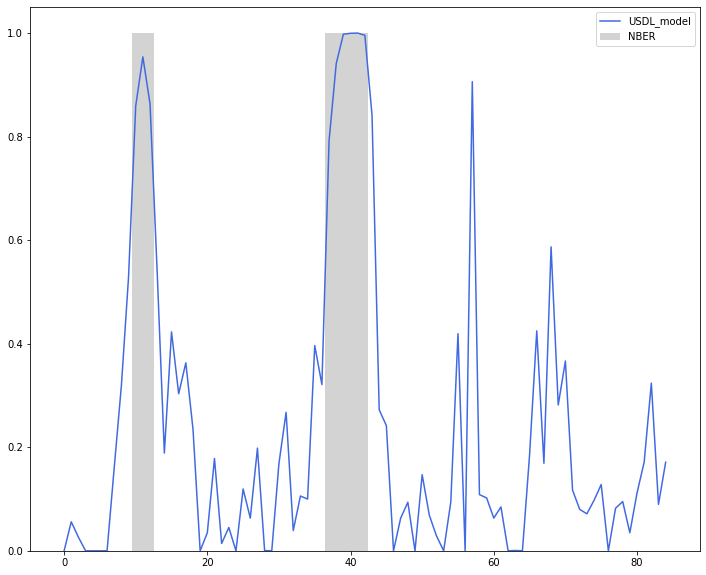

In [ ]:
USDL_model = model.predict(test_features)
time_axis = range(0,test_labels.shape[0])
plt.bar(time_axis, test_labels.T, width=1, linewidth=1, align='center', color="lightgray", label='NBER') 
plt.plot(time_axis, USDL_model, 'b-', color="royalblue", label='USDL_model')
plt.legend()
plt.show()

#### Confusion matrix

We can use a [confusion matrix](https://developers.google.com/machine-learning/glossary/#confusion_matrix) to summarize the actual vs. predicted labels.

In [ ]:
test_predictions_baseline = model.predict(test_features)

In [ ]:
#test_predictions_baseline_2dim = test_predictions_baseline[:, :, 0]

In [ ]:
def plot_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('Expansions Detected (True Negatives): ', cm[0][0])
  print('Expansions Incorrectly Detected (False Positives): ', cm[0][1])
  print('Recessions Missed (False Negatives): ', cm[1][0])
  print('Recessions Detected (True Positives): ', cm[1][1])
  print('Total Recessions: ', np.sum(cm[1]))

Evaluate the model on the TEST dataset and display the results for the metrics you created above.

loss :  0.20690102875232697
tp :  9.0
fp :  5.0
tn :  71.0
fn :  0.0
accuracy :  0.9411764740943909
precision :  0.6428571343421936
recall :  1.0
auc :  0.9941520690917969

Expansions Detected (True Negatives):  71
Expansions Incorrectly Detected (False Positives):  5
Recessions Missed (False Negatives):  0
Recessions Detected (True Positives):  9
Total Recessions:  9


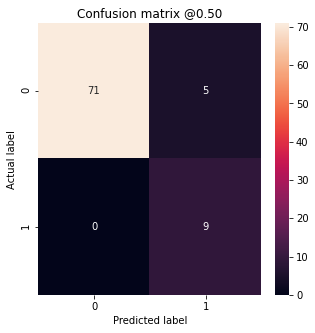

In [ ]:
baseline_results = model.evaluate(test_features, test_labels, verbose=0)
for name, value in zip(model.metrics_names, baseline_results):
  print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_baseline)

##Transfer Learning | Brazil and EURO

###Brazil

#### Data

All data refer to Brazil from 2000Q1 to 2019Q4.

>Column| Source| Description| Feature Type | Data Type
>------------|--------------------|----------------------|-----------------|----------------
>GDP | FRED-MD | NAEXKP01BRQ652S - Total Gross Domestic Product, s.a. | Numerical | float
>Income | FRED-MD | NAEXKP02BRQ189S - Private Final Consumption Expenditure, s.a. | Numerical | float
>Employment | BCB | Registered Employees Index, s.a. | Numerical | float
>Industry | FRED-MD | BRAPROINDQISMEI - Production of Total Industry, s.a. | Numerical | float
>Sales | FRED-MD | BRASARTQISMEI - Total Retail Trade, s.a. | Numerical | float
>Target | CODACE | CODACE based Recession Indicator (1 = true; 0 = false) | Classification | integer

In [ ]:
BR_raw_data = pd.read_csv('https://raw.githubusercontent.com/rrsguim/PhD_Economics/master/NN4BC/TL4BC_Brazil_data.csv')

In [ ]:
BR_raw_data.index = BR_raw_data['DATE']
drop_DATE = BR_raw_data.pop('DATE')
BR_raw_data.index = pd.to_datetime(BR_raw_data.index,infer_datetime_format=True)
BR_raw_data.index = BR_raw_data.index.to_period("Q")

In [ ]:
BR_log_data = BR_raw_data.copy()

BR_log_data['GDP'] = np.log(BR_log_data['GDP'])
BR_log_data['Income'] = np.log(BR_log_data['Income'])
BR_log_data['Employment'] = np.log(BR_log_data['Employment'])
BR_log_data['Industry'] = np.log(BR_log_data['Industry'])
BR_log_data['Sales'] = np.log(BR_log_data['Sales'])

In [ ]:
BR_log_1df = BR_log_data.copy()

BR_log_1df['GDP'] = BR_log_data['GDP'] - BR_log_data['GDP'].shift(1)
BR_log_1df['Income'] = BR_log_data['Income'] - BR_log_data['Income'].shift(1)
BR_log_1df['Employment'] = BR_log_data['Employment'] - BR_log_data['Employment'].shift(1)
BR_log_1df['Industry'] = BR_log_data['Industry'] - BR_log_data['Industry'].shift(1)
BR_log_1df['Sales'] = BR_log_data['Sales'] - BR_log_data['Sales'].shift(1)

In [ ]:
BR_dataset_copy = BR_log_1df
yBR = BR_dataset_copy.pop('CODACE')
xBR = BR_dataset_copy

In [ ]:
xBR = scaler.fit_transform(xBR)

Adjust dimb because of LSTM

In [ ]:
xBR = np.expand_dims(xBR, 1)

#### Compare with CODACE

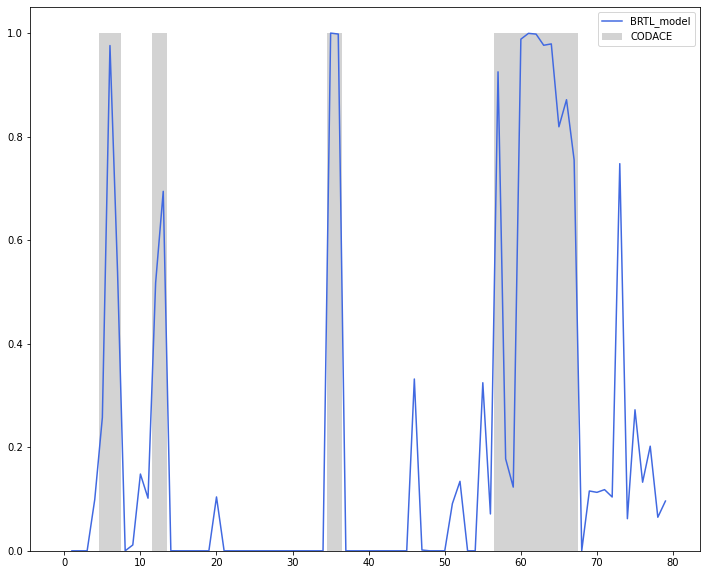

In [ ]:
#BRTL_model = model.predict(scaler.fit_transform(xBR)) 
BRTL_model = model.predict(xBR) 
time_axis = range(0,yBR.shape[0])
plt.bar(time_axis, yBR.T, width=1, linewidth=1, align='center', color="lightgray", label='CODACE') 
plt.plot(time_axis, BRTL_model, 'b-', color="royalblue", label='BRTL_model')
plt.legend()
plt.show()

#### Confusion matrix

loss :  [nan]
tp :  [4.752667e-12]
fp :  [7.2344504e-09]
tn :  [3.849404e-06]
fn :  [0.09908763]
accuracy :  [0.25754207]
precision :  [0.97591287]
recall :  [0.5368965]
auc :  [1.5378354e-27]



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in greater
  


Expansions Detected (True Negatives):  61
Expansions Incorrectly Detected (False Positives):  1
Recessions Missed (False Negatives):  3
Recessions Detected (True Positives):  15
Total Recessions:  18


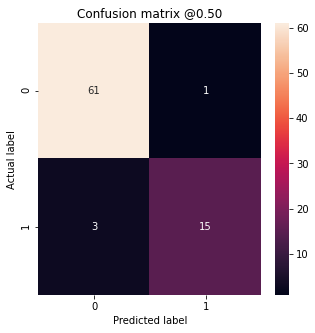

In [ ]:
BR_baseline_results = BRTL_model
for name, value in zip(model.metrics_names, BR_baseline_results):
  print(name, ': ', value)
print()

plot_cm(yBR, BR_baseline_results)

###EURO

#### Data

All data refer to Euro area from 2005Q1 to 2019Q4.

>Column| Source| Description| Feature Type | Data Type
>------------|--------------------|----------------------|-----------------|----------------
>GDP | FRED-MD | CLVMNACSCAB1GQEA19 - Real Gross Domestic Product (19 countries), s.a. | Numerical | float
>Income | FRED-MD | NAEXKP02EZQ189S - Private Final Consumption Expenditure, s.a. | Numerical | float
>Employment | FRED-MD | LFESEETTEZQ647S - Employees, s.a. | Numerical | float
>Industry | FRED-MD | PRMNTO01EZQ657S - Total Manufacturing Production, s.a. | Numerical | float
>Sales | FRED-MD | SLRTTO01EZQ657S - Volume of Total Retail Trade sales, s.a. | Numerical | float
>Target | CEPR | CEPR based Recession Indicator (1 = true; 0 = false) | Classification | integer

In [ ]:
EURO_raw_data = pd.read_csv('https://raw.githubusercontent.com/rrsguim/PhD_Economics/master/NN4BC/TL4BC_Euro_data_2005.csv')

In [ ]:
EURO_raw_data.index = EURO_raw_data['DATE']
drop_DATE = EURO_raw_data.pop('DATE')
EURO_raw_data.index = pd.to_datetime(EURO_raw_data.index,infer_datetime_format=True)
EURO_raw_data.index = EURO_raw_data.index.to_period("Q")

In [ ]:
EURO_log_data = EURO_raw_data.copy()

EURO_log_data['GDP'] = np.log(EURO_log_data['GDP'])
EURO_log_data['Income'] = np.log(EURO_log_data['Income'])
EURO_log_data['Employment'] = np.log(EURO_log_data['Employment'])
EURO_log_data['Industry'] = np.log(EURO_log_data['Industry'])
EURO_log_data['Sales'] = np.log(EURO_log_data['Sales'])

In [ ]:
EURO_log_1df = EURO_log_data.copy()

EURO_log_1df['GDP'] = EURO_log_data['GDP'] - EURO_log_data['GDP'].shift(1)
EURO_log_1df['Income'] = EURO_log_data['Income'] - EURO_log_data['Income'].shift(1)
EURO_log_1df['Employment'] = EURO_log_data['Employment'] - EURO_log_data['Employment'].shift(1)
EURO_log_1df['Industry'] = EURO_log_data['Industry'] - EURO_log_data['Industry'].shift(1)
EURO_log_1df['Sales'] = EURO_log_data['Sales'] - EURO_log_data['Sales'].shift(1)

In [ ]:
EURO_dataset_copy = EURO_log_1df
yEURO = EURO_dataset_copy.pop('CEPR')
xEURO = EURO_dataset_copy

In [ ]:
xEURO = scaler.fit_transform(xEURO)

Adjust dimb because of LSTM

In [ ]:
xEURO = np.expand_dims(xEURO, 1)

#### Compare with CEPR

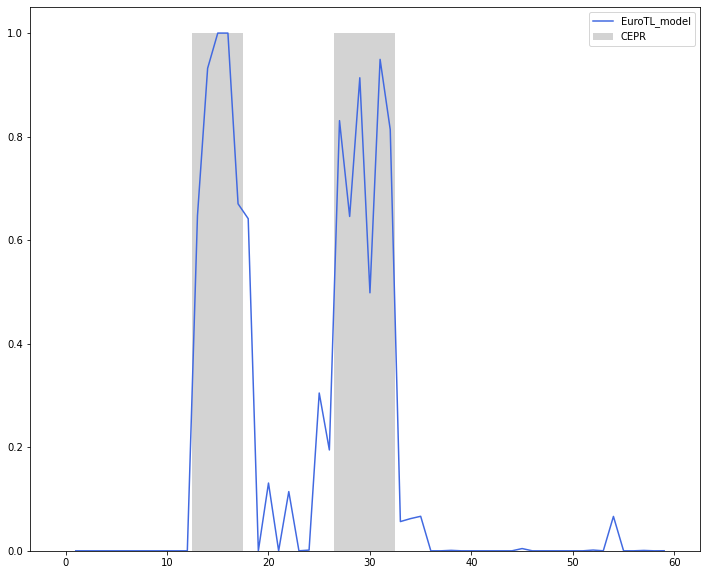

In [ ]:
#EuroTL_model = model.predict(scaler.fit_transform(xEURO)) 
EuroTL_model = model.predict(xEURO) 
time_axis = range(0,yEURO.shape[0])
plt.bar(time_axis, yEURO.T, width=1, linewidth=1, align='center', color="lightgray", label='CEPR') 
plt.plot(time_axis, EuroTL_model, 'b-', color="royalblue", label='EuroTL_model') 
plt.legend()
plt.show()

loss :  [nan]
tp :  [1.1970596e-20]
fp :  [1.10755454e-29]
tn :  [3.3665716e-36]
fn :  [1.0150197e-30]
accuracy :  [0.]
precision :  [2.3427063e-23]
recall :  [0.]
auc :  [4.6735398e-21]



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in greater
  


Expansions Detected (True Negatives):  48
Expansions Incorrectly Detected (False Positives):  1
Recessions Missed (False Negatives):  1
Recessions Detected (True Positives):  10
Total Recessions:  11


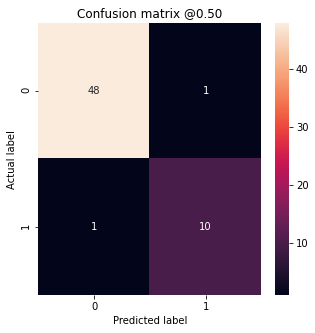

In [ ]:
Euro_baseline_results = EuroTL_model
for name, value in zip(model.metrics_names, Euro_baseline_results):
  print(name, ': ', value)
print()

plot_cm(yEURO, Euro_baseline_results)